In [1]:
from autogluon.tabular import TabularPredictor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from getS50 import getS50
import uproot
import os

In [2]:
data = np.load("/home2/hky/github/Gamma_Energy/Exptdata/crabCut_23_05_03_withisgamma_Allsky/Data.npz")

In [8]:
np.sum(data["isgamma"]>0.2)/data["isgamma"].shape[0]

0.15749735934313971

In [6]:
predictor_isgmma = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR"
)

In [2]:
paralist_MC = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "inout",
    "prie"
]


In [3]:
gammafile = uproot.open("/home2/hky/Data/MCdata/CrabRESULT.root")


In [4]:
gammafile["asresult"].keys()

['runno',
 'evno',
 'mode',
 'mjd',
 'nch',
 'inout',
 'oldtrig',
 'theta',
 'phi',
 'evenodd',
 'sigma',
 'cx',
 'cy',
 'sumpf',
 'sumpd',
 'mr1',
 'mr2',
 'summd',
 'summdold',
 'summd8',
 'nchmd',
 'ne',
 'age',
 'ndf',
 'chi2',
 'fptcl_r',
 'dptcl_r',
 'fn_r',
 'dn_r',
 'JPne',
 'JPne_err',
 'JPage_err',
 'JPage',
 'JPchi2',
 'JPdof',
 'nch_cx',
 'sigma_cx',
 'ne_cx',
 'age_cx',
 'cx_cx',
 'cy_cx',
 'theta_cx',
 'phi_cx',
 'prie_num',
 'prik',
 'priid',
 'pritheta',
 'priphi',
 'prie',
 'prine',
 'pricx',
 'pricy']

In [5]:
gammafile = uproot.open("/home2/hky/Data/MCdata/CrabRESULT.root")
gammadata = gammafile["asresult"].arrays(paralist_MC, library="np")

In [7]:
gammadata["S50"] = getS50(gammadata["ne"], gammadata["age"])
MCcut = np.where(
    (gammadata["inout"] == 1)
    & (gammadata["age"] < 1.3)
    & (gammadata["age"] > 0.31)
    & (gammadata["S50"] >= 10**-1.2)
    & (gammadata["nch"] >= 16)
    & (gammadata["theta"] < 60)
)
gammadata = {key: gammadata[key][MCcut] for key in gammadata.keys()}

gammadata["isgamma"] = predictor_isgmma.predict_proba(pd.DataFrame(gammadata))[1].to_numpy()
# gammadata["sumpf"] = np.log10(gammadata["sumpf"])


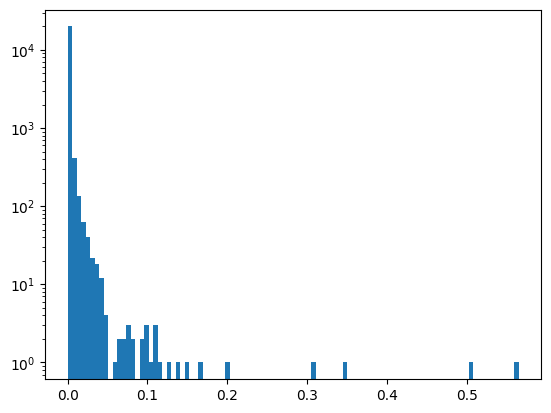

In [56]:
plt.hist(gammadata["summd"] / gammadata["sumpf"] ** 1.2,bins=100)
plt.yscale("log")

In [67]:
np.log10(np.min(gammadata["summd"] / gammadata["sumpf"] ** 1.2))

-5.129684796017878

In [74]:
np.max(gammadata["summd"] / gammadata["sumpf"] ** 1.2)

0.5650566789495635

Text(0, 0.5, 'ag output')

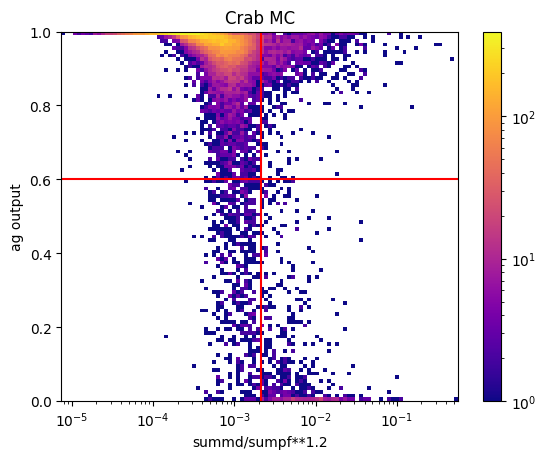

In [80]:
x_bins=np.logspace(np.log10(np.min(gammadata["summd"] / gammadata["sumpf"] ** 1.2)),np.log10(np.max(gammadata["summd"] / gammadata["sumpf"] ** 1.2)),101)
y_bins=np.linspace(0,1,101)
gammadata["summd"][gammadata["summd"]==0]=10**-0.6
hist, _, _ = np.histogram2d(
    gammadata["summd"] / gammadata["sumpf"] ** 1.2,
    gammadata["isgamma"],
    bins=(x_bins,y_bins)
)
fig, axs = plt.subplots()
c = axs.pcolormesh(x_bins, y_bins, hist.T, cmap="plasma",norm="log")
B = fig.colorbar(c, orientation="vertical")
plt.xscale("log")
plt.axhline(0.6,c="r")
plt.axvline(2.1e-3,c="r")
plt.title("Crab MC")
plt.xlabel("summd/sumpf**1.2")
plt.ylabel("ag output")

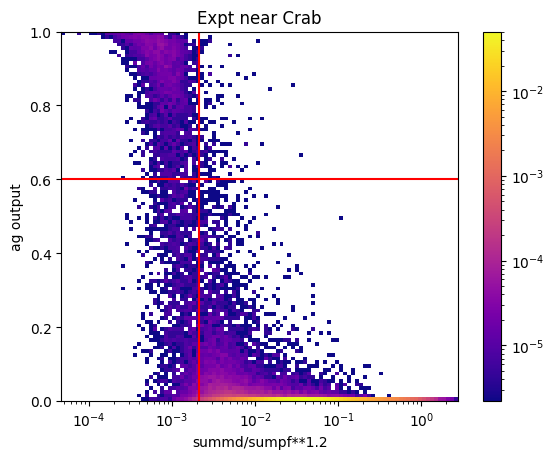

In [36]:
Exptdata = np.load("/home2/hky/github/Gamma_Energy/Exptdata/mergedData_nearcrab.npz")
Exptdata = {key: Exptdata[key] for key in Exptdata.keys()}
Exptdata["isgamma"] = predictor_isgmma.predict_proba(pd.DataFrame(Exptdata))[
    1
].to_numpy()
Exptdata["summd"][Exptdata["summd"] == 0] = 10**-0.6

x_bins = np.logspace(
    np.log10(np.min(Exptdata["summd"] / Exptdata["sumpf"] ** 1.2)),
    np.log10(np.max(Exptdata["summd"] / Exptdata["sumpf"] ** 1.2)),
    101,
)
y_bins = np.linspace(0, 1, 101)
hist, _, _ = np.histogram2d(
    Exptdata["summd"] / Exptdata["sumpf"] ** 1.2,
    Exptdata["isgamma"],
    bins=(x_bins, y_bins),
    # normed=True
)
hist/=np.sum(hist)
fig, axs = plt.subplots()
c = axs.pcolormesh(x_bins, y_bins, hist.T, cmap="plasma", norm="log")
B = fig.colorbar(c, orientation="vertical")
plt.xscale("log")
plt.axhline(0.6, c="r")
plt.axvline(2.1e-3, c="r")
plt.title("Expt near Crab")
plt.xlabel("summd/sumpf**1.2")
plt.ylabel("ag output")
plt.show()


In [37]:
paralist_Expt = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
]
CRdata = dict()
for key in paralist_Expt:
    CRdata[key] = list()
for root, dirs, files in os.walk(
    "/home2/hky/github/Gamma_Energy/Exptdata/crabcutData_eqzenith", topdown=False
):
    for name in files:
        Exptdata_tmp = np.load(os.path.join(root, name))

        Exptcut = np.where((Exptdata_tmp["Dec"] < 23) & (Exptdata_tmp["Dec"] > 21))
        for key in paralist_Expt:
            CRdata[key].append(Exptdata_tmp[key][Exptcut])
CRdata={key:np.concatenate(CRdata[key]) for key in CRdata.keys()}

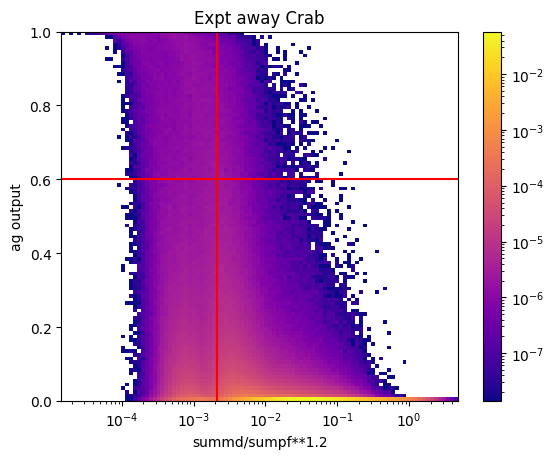

In [39]:
CRdata["isgamma"] = predictor_isgmma.predict_proba(pd.DataFrame(CRdata))[1].to_numpy()

CRdata["summd"][CRdata["summd"]==0]=10**-0.6
x_bins=np.logspace(np.log10(np.min(CRdata["summd"] / CRdata["sumpf"] ** 1.2)),np.log10(np.max(CRdata["summd"] / CRdata["sumpf"] ** 1.2)),101)
y_bins=np.linspace(0,1,101)
hist2, _, _ = np.histogram2d(
    CRdata["summd"] / CRdata["sumpf"] ** 1.2,
    CRdata["isgamma"],
    bins=(x_bins,y_bins)
)
hist2/=np.sum(hist2)

fig, axs = plt.subplots()
c = axs.pcolormesh(x_bins, y_bins, hist2.T, cmap="plasma",norm="log")
B = fig.colorbar(c, orientation="vertical")
plt.xscale("log")
plt.axhline(0.6,c="r")
plt.axvline(2.1e-3,c="r")
plt.title("Expt away Crab")
plt.xlabel("summd/sumpf**1.2")
plt.ylabel("ag output")
plt.show()

/tmp/ipykernel_2082258/3224160438.py:2: RuntimeWarning: divide by zero encountered in divide
  c = axs.pcolormesh(x_bins, y_bins,  hist.T/hist2.T, cmap="plasma",norm="log")
/tmp/ipykernel_2082258/3224160438.py:2: RuntimeWarning: invalid value encountered in divide
  c = axs.pcolormesh(x_bins, y_bins,  hist.T/hist2.T, cmap="plasma",norm="log")


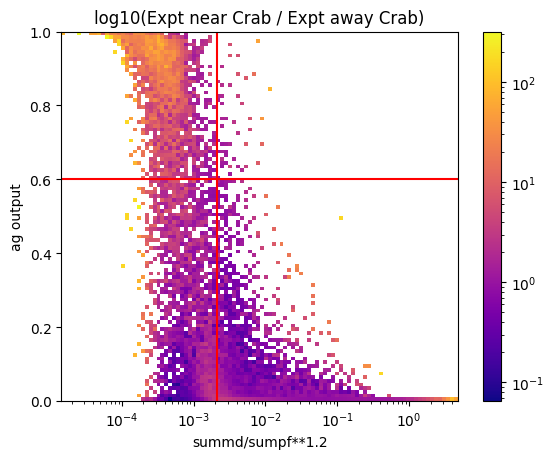

In [48]:
fig, axs = plt.subplots()
c = axs.pcolormesh(x_bins, y_bins,  hist.T/hist2.T, cmap="plasma",norm="log")
B = fig.colorbar(c, orientation="vertical")
plt.xscale("log")
plt.axhline(0.6,c="r")
plt.axvline(2.1e-3,c="r")
plt.title("log10(Expt near Crab / Expt away Crab)")
plt.xlabel("summd/sumpf**1.2")
plt.ylabel("ag output")
plt.show()

In [64]:
np.max(gammadata["energy"])

1404.2263

In [66]:
sumpf = 10**gammadata["sumpf"][np.where(gammadata["energy"]>100)]
summd = gammadata["summd"][np.where(gammadata["energy"]>100)]

In [67]:
np.sum((summd<0.4)|(summd<2.1e-3*sumpf**1.2))/summd.shape[0]

0.9184188393608074

In [65]:
summd.shape[0]

1189

In [49]:
test_data_tmp = test_data[10**test_data["energy"]>energymin]
np.sum(test_data_tmp["isgamma"] == 1)

459

In [2]:
test_data = np.load(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/test_Data_part.npz"
)

In [3]:
columns_need = [
    "nch",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
    "sigma",
    "phi",
    "theta",
    "isgamma",
]

In [4]:
test_data = pd.DataFrame({key: test_data[key] for key in columns_need})

In [6]:
predictor_energy = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_withoutcut/log10Energy"
)
test_data["sumpf"] = np.log10(test_data["sumpf"])

In [7]:
test_data["energy"]= predictor_energy.predict(test_data)

In [76]:
for energymin in [0, 10, 25, 50, 100]:
    test_data_tmp = test_data[10 ** test_data["energy"] > energymin]
    ac = np.sum(
        test_data_tmp[
            (test_data_tmp["summd"] < 0.4)
            | (test_data_tmp["summd"] < 2e-3 * 10 ** test_data_tmp["sumpf"] ** 1.2)
        ]["isgamma"]
        == 1
    ) / np.sum(
        (test_data_tmp["summd"] < 0.4)
        | (test_data_tmp["summd"] < 2e-3 * 10 ** test_data_tmp["sumpf"] ** 1.2)
    )
    eff = np.sum(
        test_data_tmp[
            (test_data_tmp["summd"] < 0.4)
            | (test_data_tmp["summd"] < 2e-3 * 10 ** test_data_tmp["sumpf"] ** 1.2)
        ]["isgamma"]
        == 1
    ) / np.sum(test_data_tmp["isgamma"] == 1)
    CR = 1 - np.sum(
        test_data_tmp[
            (test_data_tmp["summd"] < 0.4)
            | (test_data_tmp["summd"] < 2e-3 * 10 ** test_data_tmp["sumpf"] ** 1.2)
        ]["isgamma"]
        == 0
    ) / np.sum(test_data_tmp["isgamma"] == 0)
    print(energymin, f"{ac*100:.4f}%", f"{eff*100:.4f}%", f"{CR*100:.4f}%")


0 18.2547% 91.2868% 98.9535%
10 19.4112% 91.6340% 99.1589%
25 25.2795% 92.7204% 99.5267%
50 31.1765% 92.9825% 99.6862%
100 33.1787% 93.4641% 99.7732%


In [73]:
predictor = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR"
)


In [74]:
pred = predictor.predict_proba(test_data)

In [77]:
for energymin in [0, 10, 25, 50, 100]:
    for cut in np.linspace(0.01, 0.99, 99):
        ac = np.sum(
            (pred[1][10 ** test_data["energy"] > energymin] > cut)
            & (test_data["isgamma"][10 ** test_data["energy"] > energymin] == 1)
        ) / np.sum(pred[1][10 ** test_data["energy"] > energymin] > cut)
        eff = np.sum(
            (pred[1][10 ** test_data["energy"] > energymin] > cut)
            & (test_data["isgamma"][10 ** test_data["energy"] > energymin] == 1)
        ) / np.sum(test_data["isgamma"][10 ** test_data["energy"] > energymin] == 1)
        CR = np.sum(
            (pred[1][10 ** test_data["energy"] > energymin] < cut)
            & (test_data["isgamma"][10 ** test_data["energy"] > energymin] == 0)
        ) / np.sum(test_data["isgamma"][10 ** test_data["energy"] > energymin] == 0)
        print(
            energymin,
            f"{cut:.2f}",
            f"{ac*100:.4f}%",
            f"{eff*100:.4f}%",
            f"{CR*100:.4f}%",
        )


0 0.01 26.7212% 87.0830% 99.3886%
0 0.02 28.9296% 85.5799% 99.4618%
0 0.03 30.2962% 84.3578% 99.5031%
0 0.04 31.2609% 83.4413% 99.5303%
0 0.05 32.1264% 82.8425% 99.5519%
0 0.06 32.8027% 82.0848% 99.5695%
0 0.07 33.4218% 81.5960% 99.5839%
0 0.08 33.9754% 81.0461% 99.5968%
0 0.09 34.4006% 80.4839% 99.6071%
0 0.10 34.7167% 79.7385% 99.6161%
0 0.11 35.0601% 79.1519% 99.6247%
0 0.12 35.4958% 78.6997% 99.6339%
0 0.13 35.8806% 78.3209% 99.6417%
0 0.14 36.2422% 77.9054% 99.6491%
0 0.15 36.5790% 77.3555% 99.6566%
0 0.16 36.8727% 76.8545% 99.6631%
0 0.17 37.1530% 76.3901% 99.6692%
0 0.18 37.5053% 76.0235% 99.6757%
0 0.19 37.7646% 75.4369% 99.6817%
0 0.20 38.0229% 74.9725% 99.6871%
0 0.21 38.3441% 74.5937% 99.6929%
0 0.22 38.6427% 74.1782% 99.6985%
0 0.23 38.8914% 73.6527% 99.7037%
0 0.24 39.0691% 73.1394% 99.7080%
0 0.25 39.3805% 72.7117% 99.7135%
0 0.26 39.6751% 72.2229% 99.7189%
0 0.27 39.9374% 71.7341% 99.7238%
0 0.28 40.2514% 71.2208% 99.7293%
0 0.29 40.5472% 70.8175% 99.7342%
0 0.30 40.8556

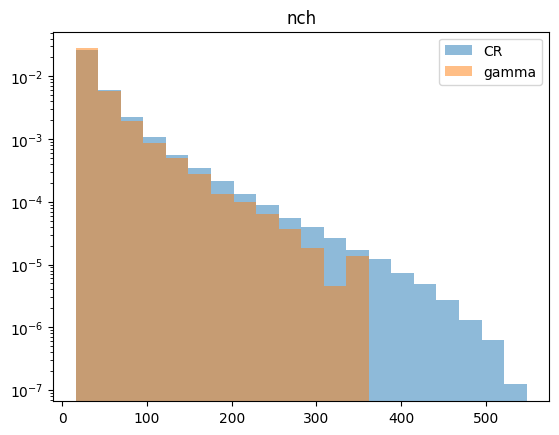

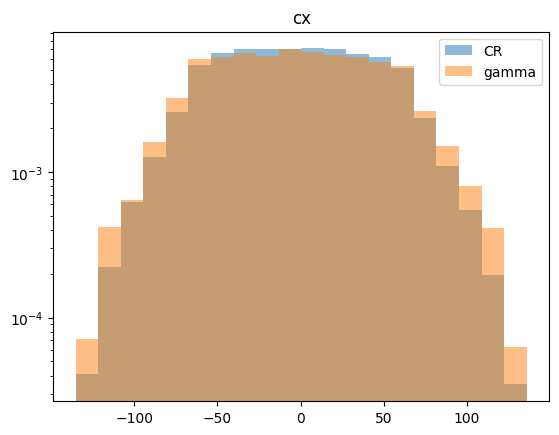

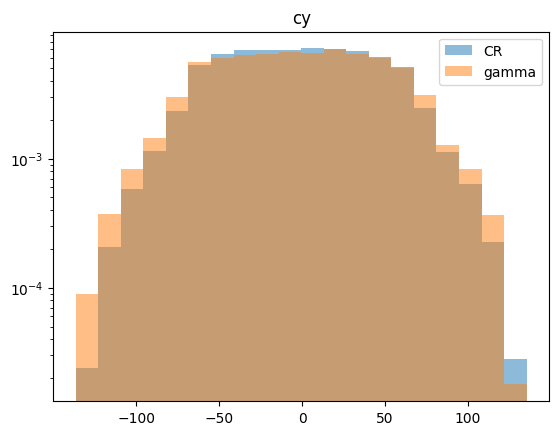

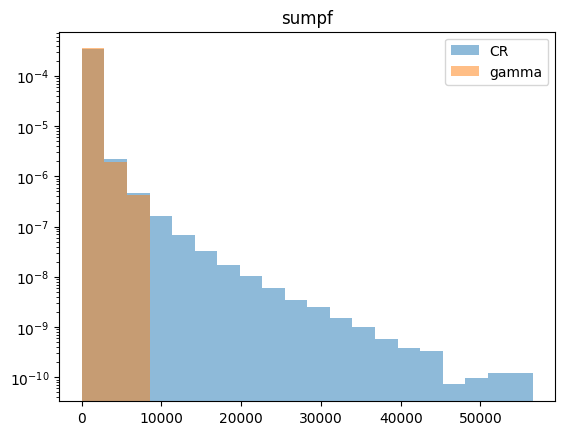

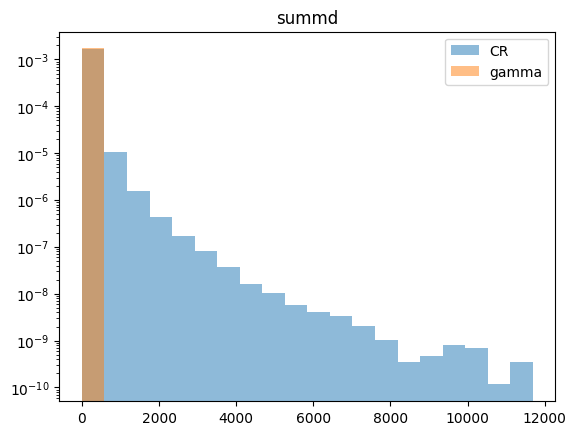

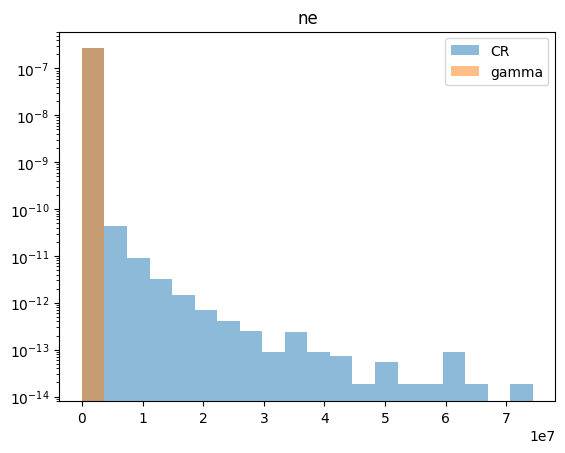

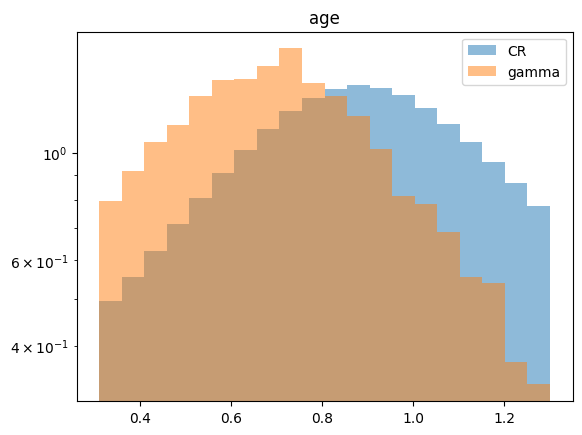

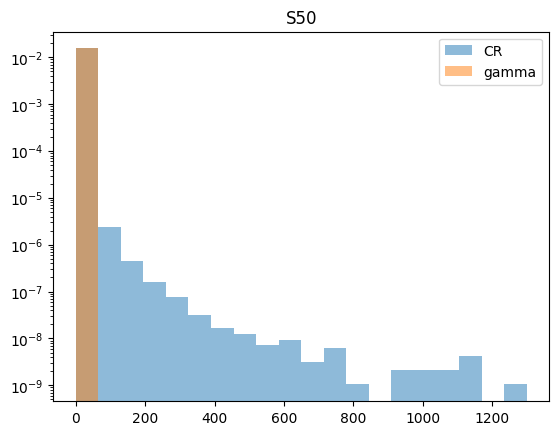

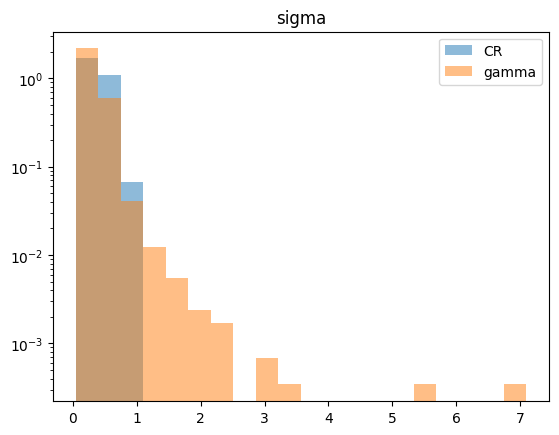

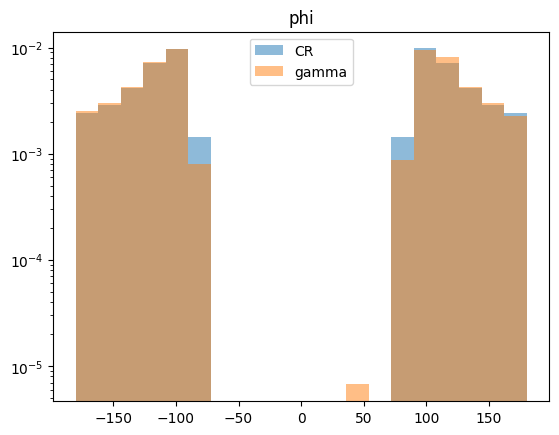

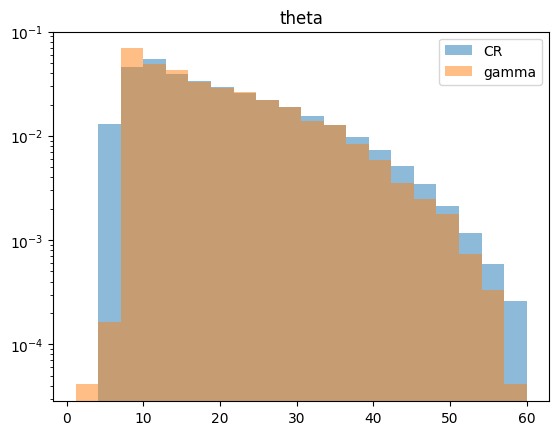

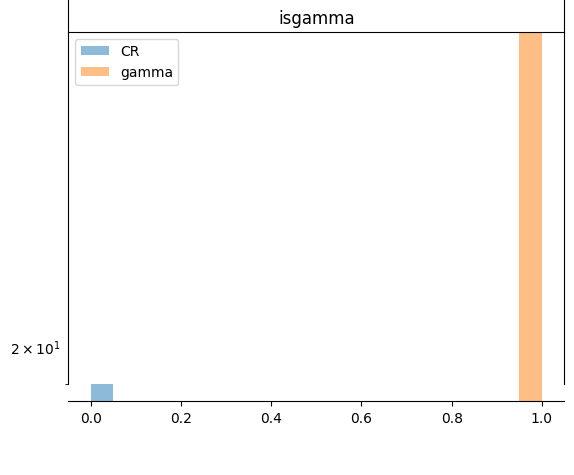

In [5]:
for para in columns_need :
    bins=20
    plt.hist(test_data[para][test_data["isgamma"]==0],bins=bins,range=(np.min(test_data[para]),np.max(test_data[para])),label="CR",alpha=0.5,density=True)
    plt.hist(test_data[para][test_data["isgamma"]==1],bins=bins,range=(np.min(test_data[para]),np.max(test_data[para])),label="gamma",alpha=0.5,density=True)
    plt.title(para)
    plt.yscale("log")
    plt.legend()
    plt.show()